In [14]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.4.0-dev20200718
Is using GPU? False


In [15]:
# pets.download_and_extract('data','.')

In [16]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples: ', count_train)
print('Test examples: ', count_test)

Training examples:  3680
Test examples:  3669


In [17]:
image_dir = 'data/images/'

def get_random_batch(annot, batch_size = 4):
  all_keys = list(annot.keys())
  total_examples = len(all_keys)

  indices = np.random.choice(range(total_examples), batch_size)

  x = np.zeros((batch_size, 128,128,3))
  y = np.zeros((batch_size,1))

  images = []

  for i, index in enumerate(indices):
    image_path = os.path.join(image_dir, all_keys[index])
    image = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(128,128)
    )
    arr = tf.keras.preprocessing.image.img_to_array(image)
    arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
    arr = np.expand_dims(arr,axis=0)
    x[i] = arr
    y[i] = class_to_index[annot[all_keys[index]]]
    images.append(image)

  return x,y, images

Displaying first 8 examples..


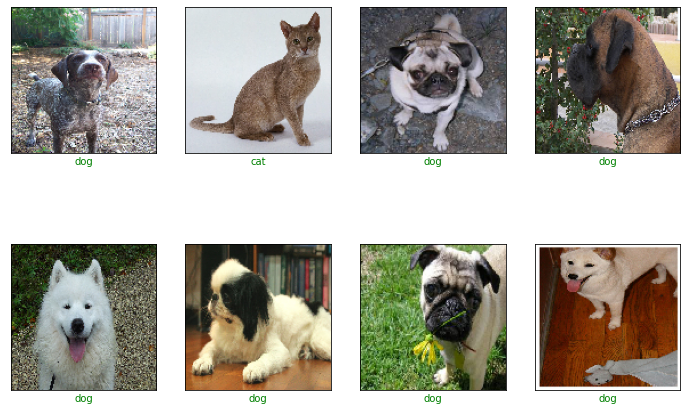

In [18]:
x, y, images = get_random_batch(train_annot,batch_size=8)
pets.display_examples(x,y,y,images,index_to_class).show()

In [19]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,pooling='avg',weights='imagenet',
    input_shape=(128,128,3)
)
mnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
def create_model():
  model = tf.keras.models.Sequential([
    mnet,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.layers[0].trainable = False
  model.compile(loss='binary_crossentropy', optimizer='adam',
                metrics=['accuracy'])
  
  return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
def data_generator(batch_size, annot):
  while True:
    x, y, _ = get_random_batch(annot,batch_size)
    yield (x, y)

In [9]:
batch_size = 32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_test/batch_size)

print("Training steps: ", steps_per_epoch)
print('Validation steps:', validation_steps)

Training steps:  115
Validation steps: 114


In [11]:
%%time

_ = model.fit(
    data_generator(batch_size,train_annot),
    validation_data=data_generator(batch_size,test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=1
)

115/115 [==============================] - 148s 1s/step - loss: 0.1076 - accuracy: 0.9671 - val_loss: 0.0760 - val_accuracy: 0.9740
Wall time: 2min 28s


# Task 6: Predictions

In [24]:
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Displaying first 8 examples..


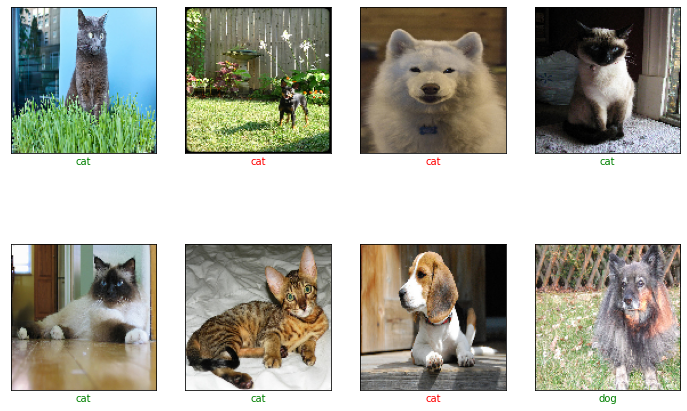

In [25]:
pets.display_examples(x, y, preds,images, index_to_class).show()